# Instalación de Librerías

In [39]:
!pip install umap-learn hdbscan

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [40]:
pip install "bertopic" "plotly<6.0.0"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


# Importacíon de las librerías

In [41]:
import pandas as pd
import numpy as np
import torch
import random
import os
from typing import List, Dict, Any

# Configuración de semilla global

In [42]:
def set_global_seed(seed: int = 42):
    """Establece semilla global para reproducibilidad completa"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    # Para UMAP y HDBSCAN
    os.environ['UMAP_RANDOM_STATE'] = str(seed)

# Establecer semilla al inicio
GLOBAL_SEED = 123
set_global_seed(GLOBAL_SEED)

In [43]:
# Mostrar cuántas GPUs hay disponibles
num_gpus = torch.cuda.device_count()
print(f"Número de GPUs disponibles: {num_gpus}")

# Mostrar información de cada GPU
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

Número de GPUs disponibles: 4
GPU 0: NVIDIA L4
GPU 1: NVIDIA L4
GPU 2: NVIDIA A100 80GB PCIe
GPU 3: NVIDIA A100-PCIE-40GB


In [44]:
gpu_id = 2  # Usamos la GPU 2

if gpu_id < num_gpus:
    device = torch.device(f"cuda:{gpu_id}")
    print(f"Usando GPU {gpu_id}: {torch.cuda.get_device_name(gpu_id)}")
else:
    device = torch.device("cpu")
    print(f"GPU {gpu_id} no disponible. Usando CPU.")

Usando GPU 2: NVIDIA A100 80GB PCIe


# Carga y preprocesamiento de los datos

In [45]:
print("Cargando datos...")
df = pd.read_csv('emails.csv')
documentos = df['body'].astype(str).tolist()
asuntos = df['subject'].astype(str).tolist()

# Preprocesamiento básico para mejorar calidad
def preprocess_text(texts: List[str]) -> List[str]:
    """Preprocesamiento ligero para emails"""
    processed = []
    for text in texts:
        # Mantener estructura original pero limpiar caracteres problemáticos
        text = text.replace('\n', ' ').replace('\t', ' ')
        text = ' '.join(text.split())  # Normalizar espacios
        processed.append(text)
    return processed

documentos = preprocess_text(documentos)
asuntos = preprocess_text(asuntos)

print(f"Total de emails cargados: {len(documentos)}")
print(f"Longitud promedio: {np.mean([len(doc.split()) for doc in documentos]):.1f} palabras")
print(f"Ejemplo de email:")
print(documentos[0][:500] + "..." if len(documentos[0]) > 500 else documentos[0])

Cargando datos...
Total de emails cargados: 10000
Longitud promedio: 142.2 palabras
Ejemplo de email:
high quality pills canadian pharmacy presents cheapest viagra pills online buy quality pills without leaving your computer and we ll send them directly to your home no prescriptions check it out it s ten times cheaper and same quality click to buy viagra for the lowest price on the web


# Configuración del modelo LLM

In [46]:
from torch import cuda, bfloat16
import transformers

model_id = 'HuggingFaceH4/zephyr-7b-alpha'
print(f"Usando dispositivo: {device}")

# Configuración optimizada de cuantización para A100/L4
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)

# Tokenizer y modelo
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,  # Activar cuantización para optimizar memoria
    device_map='auto',
    torch_dtype=bfloat16,
)
model.eval()

# Pipeline optimizado para clustering
generator = transformers.pipeline(
    model=model, 
    tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)

Usando dispositivo: cuda:2


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Device set to use cuda:0


# Prompts optimizados para clustering

In [47]:
system_prompt = """<|system|>
You are an expert in text analysis and topic modeling.
Your task is to analyze email clusters and create clear, descriptive labels that summarize the main topic or theme of each cluster.</s>
"""

example_prompt = """<|user|>
Topic emails:
- Microsoft account: Unusual sign-in activity detected from new device in Russia. Verify your identity immediately to secure your account.
- We've detected suspicious activity on your Microsoft account. Someone tried to access your files from an unrecognized location. Click here to review and secure your account now.
- Your Microsoft account was accessed from a new device. If this wasn't you, please verify your identity within 24 hours to prevent unauthorized access.
- ALERT: Microsoft account security - Unusual sign-in from unknown location detected. Immediate action required to protect your data.
Keywords: 'microsoft, account, unusual, sign-in, activity, detected, device, location, verify, identity, security, suspicious, access'
Based on the emails and keywords above, create a specific phishing category label that includes the target brand and attack type.</s>
<|assistant|>
Microsoft Account Unusual Sign-Ins</s>
"""
main_prompt = """<|user|>
I have a topic that contains the following emails:
[DOCUMENTS]
The topic is described by the following keywords: '[KEYWORDS]'.
Based on the information above, create a short descriptive label (max 5 words) that summarizes this email topic.</s>
<|assistant|>
"""

prompt = system_prompt + example_prompt + main_prompt

# Modelo de embeddings

In [48]:
from sentence_transformers import SentenceTransformer

# Modelo optimizado para emails y detección de phishing
embedding_model = SentenceTransformer(
    "all-MiniLM-L6-v2",  # Más eficiente que mpnet para este caso
    device=device
)

print("Generando embeddings...")
embeddings = embedding_model.encode(
    documentos, 
    show_progress_bar=True,
    batch_size=32,  # Optimizado para GPU
    convert_to_numpy=True,
    normalize_embeddings=True  # Importante para clustering
)

Generando embeddings...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

# UMAP y HDBSCAN

In [49]:
from umap import UMAP
from hdbscan import HDBSCAN

umap_model = UMAP(n_neighbors=20, n_components=10, min_dist=0.0, metric='cosine', random_state=GLOBAL_SEED)
hdbscan_model = HDBSCAN(min_cluster_size=30, metric='euclidean', cluster_selection_method='eom', prediction_data=True)


print("Reduciendo dimensionalidad para visualización...")
reduced_embeddings = UMAP(n_neighbors=20, n_components=2, min_dist=0.0, metric='cosine', random_state=GLOBAL_SEED).fit_transform(embeddings)

Reduciendo dimensionalidad para visualización...


# Modelos de representación

In [50]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

# KeyBERT más específico
keybert = KeyBERTInspired()

# MMR con mayor diversidad
mmr = MaximalMarginalRelevance(diversity=0.3)


zephyr = TextGeneration(generator, prompt=prompt)


representation_model = {
    "KeyBERT": keybert,
    "Zephyr": zephyr,
    "MMR": mmr,
}


# Configuración BERTopic

In [51]:
from bertopic import BERTopic
topic_model = BERTopic(
    # Sub-modelos
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    representation_model=representation_model,

    # Hiperparámetros
    top_n_words=10,
    verbose=True
)

# Entrenamiento y análisis

In [52]:
print("\nEntrenando modelo BERTopic...")
topics, probs = topic_model.fit_transform(documentos, embeddings)

# Análisis de resultados
print(f"\nNúmero total de topics encontrados: {len(set(topics))}")
print(f"Número de outliers (topic -1): {list(topics).count(-1)}")

# Información detallada de topics
topic_info = topic_model.get_topic_info()
print("\nInformación de topics:")
print(topic_info.head(10))

# Ejemplo de representación KeyBERT y MMR
if len(topic_info) > 1:
    sample_topic = topic_info.iloc[1]['Topic']
    print(f"\nEjemplo de topic {sample_topic}:")
    print("KeyBERT:", topic_model.get_topic(sample_topic, full=True)["KeyBERT"])
    print("MMR:", topic_model.get_topic(sample_topic, full=True)["MMR"])

2025-06-02 13:35:59,948 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm



Entrenando modelo BERTopic...


2025-06-02 13:36:27,006 - BERTopic - Dimensionality - Completed ✓
2025-06-02 13:36:27,014 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-02 13:36:27,506 - BERTopic - Cluster - Completed ✓
2025-06-02 13:36:27,513 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 59/59 [01:42<00:00,  1.73s/it]
2025-06-02 13:38:20,228 - BERTopic - Representation - Completed ✓



Número total de topics encontrados: 59
Número de outliers (topic -1): 1689

Información de topics:
   Topic  Count                                  Name  \
0     -1   1689                    -1_to_your_the_you   
1      0   1107                   0_ect_enron_hou_the   
2      1    713                       1_my_of_your_me   
3      2    477                   2_linux_rpm_list_ie   
4      3    434              3_perl_beginners_org_use   
5      4    402  4_of_language_university_linguistics   
6      5    360            5_inches_and_more_increase   
7      6    311                6_razor_lists_spam_net   
8      7    303                 7_python_dev_org_3000   
9      8    291                  8_ethz_stat_ch_guide   

                                      Representation  \
0  [to, your, the, you, and, for, of, com, this, is]   
1  [ect, enron, hou, the, 2001, to, 2000, on, sub...   
2   [my, of, your, me, in, you, to, this, will, the]   
3  [linux, rpm, list, ie, it, speakup, the, ilug

In [53]:
print("\nEjemplo de topic con representación KeyBERT:")
print(topic_model.get_topic(10, full=True)["Zephyr"])


Ejemplo de topic con representación KeyBERT:
[('Monkey Org Email Verification Requests', 1), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0)]


In [54]:
topic_model.get_topic_info(56)

,Topic,Count,Name,Representation,KeyBERT,Zephyr,MMR,Representative_Docs
0,56,30,56_viagra_harmony_drugstores_bed,"[viagra, harmony, drugstores, bed, pharmacy, v...","[viagra, drugstores, drugstore, prescription, ...","[Online Viagra Discounts, , , , , , , , , ]","[viagra, drugstores, vyigra, expenses, pills, ...",[i got something to tell you excellence in bed...


In [55]:
zephyr_labels = [label[0][0].split("\n")[0] for label in topic_model.get_topics(full=True)["Zephyr"].values()]
topic_model.set_topic_labels(zephyr_labels)


In [56]:
topic_model.visualize_documents(asuntos, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)

In [57]:
topic_model.visualize_topics()

In [58]:
topic_model.visualize_hierarchy()


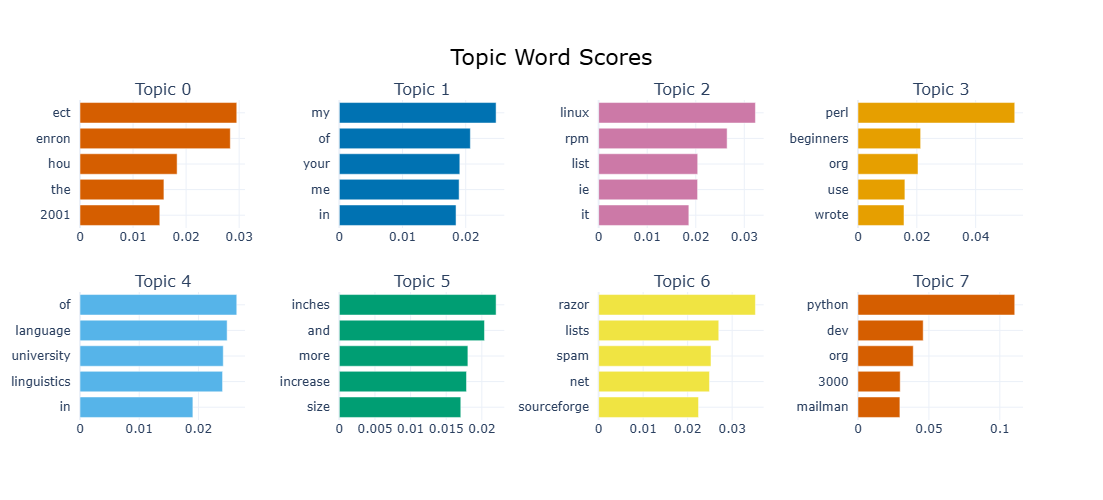

In [59]:
topic_model.visualize_barchart()


# Guardamos el nuevo dataset con el label del clúster para cada correo

In [62]:
topic_info = topic_model.get_topic_info()
print("Información de Tópicos con Etiquetas Personalizadas:")
print(topic_info.head())

Información de Tópicos con Etiquetas Personalizadas:
   Topic  Count                      Name  \
0     -1   1689        -1_to_your_the_you   
1      0   1107       0_ect_enron_hou_the   
2      1    713           1_my_of_your_me   
3      2    477       2_linux_rpm_list_ie   
4      3    434  3_perl_beginners_org_use   

                             CustomName  \
0  Email Promotions Opt-In Verification   
1     Enron Meetings and Communications   
2          Foreign Investment Proposals   
3             Linux RPM List Discussion   
4              Perl Beginners Resources   

                                      Representation  \
0  [to, your, the, you, and, for, of, com, this, is]   
1  [ect, enron, hou, the, 2001, to, 2000, on, sub...   
2   [my, of, your, me, in, you, to, this, will, the]   
3  [linux, rpm, list, ie, it, speakup, the, ilug,...   
4  [perl, beginners, org, use, wrote, it, the, fi...   

                                             KeyBERT  \
0  [email, mailing, mail

In [73]:
topic_label_map = dict(zip(topic_info.Topic, topic_info.CustomName))

# 2. Mapear la lista de tópicos de cada documento a su etiqueta de texto.
#    La variable 'topics' la creaste antes con topic_model.fit_transform()
document_labels = [topic_label_map[topic_id] for topic_id in topics]

# 3. Añadir la lista de etiquetas como una nueva columna en tu DataFrame 'df'
df['label_bertopic'] = document_labels

# --- Verificación Final ---
print("\n¡Columna añadida con éxito!")
print("Revisando las primeras 10 filas del DataFrame con la nueva etiqueta:")

# Imprime el asunto y la etiqueta del tópico para verificar
print(df[['subject', 'label_bertopic']].head(10))

# También puedes contar cuántos emails hay por cada tópico para ver la distribución
print("\nDistribución de correos por tópico:")
print(df['label_bertopic'].value_counts())


¡Columna añadida con éxito!
Revisando las primeras 10 filas del DataFrame con la nueva etiqueta:
                                             subject  \
0                                       Re.Important   
1                                      Join Us Today   
2  What to look for when purchasing a replica watch!   
3                         best products the industry   
4  funnyreign@speedy.uwaterloo.ca, See your favor...   
5                        [Mhln] Human Growth Hormone   
6         $500 sams club gift card at no cost to you   
7                          Medications that you need   
8  We need consumers to Test (and Keep) Hi Defini...   
9                                 Benefits of Viagra   

                          label_bertopic  
0                Online Viagra Discounts  
1       Home-based income opportunities.  
2                   Replica Watch Offers  
3                   Replica Watch Offers  
4                   Rewards Offer Emails  
5                Weight Los

In [75]:
print(df.head())
df.to_csv('emails_with_label_bertopic.csv')

  source                                            subject  \
0   TREC                                       Re.Important   
1   TREC                                      Join Us Today   
2   TREC  What to look for when purchasing a replica watch!   
3   TREC                         best products the industry   
4   TREC  funnyreign@speedy.uwaterloo.ca, See your favor...   

                                                body  contains_html  \
0  high quality pills canadian pharmacy presents ...          False   
1  conquer your fears and find out exactly what a...          False   
2  vip r e p l i c a w a t c h e s if you are loo...           True   
3  get the finest watch replicas we only sell pre...          False   
4  dear hockey fan don t miss this exciting oppor...          False   

   body_forms  has_attachment  \
0       False           False   
1       False           False   
2       False           False   
3       False           False   
4       False           False